# Neural Network

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from mnist_get_images import get_images


In [2]:
mnist_path = './mnist_raw/'

In [11]:
X_train_num, y_train_num, X_test_num, y_test_num = get_images(mnist_path)
# Testing data
print(f'Dimensiones datos de entrenamiento: {X_train_num.shape} \nDimensiones datos de prueba: {X_test_num.shape}')

Dimensiones datos de entrenamiento: (60000, 28, 28) 
Dimensiones datos de prueba: (10000, 28, 28)


## Images to vectors in float32

In [18]:
X_train = X_train_num[:50_000].reshape(50_000, -1).astype(np.float32)/255
y_train = y_train_num[:50_000].reshape(50_000, 1)

x_validation = X_train_num[50_000:].reshape(10_000, -1).astype(np.float32)/255
y_validation = y_train_num[50_000:].reshape(10_000, 1)

X_test = X_test_num.copy().reshape(10_000, -1).astype(np.float32)/255
y_test = y_test_num.copy().reshape(10_000, 1)

# Testing set
print(f'X_train: {X_train.max()} \n')

# Shape
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')

print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

X_train: 1.0 

X_train: (50000, 784)
y_train: (50000, 1)
X_test: (10000, 784)
y_test: (10000, 1)


## Graph image

In [21]:
def plot_img_number(image):
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

La imagen mostrada corresponde a un: [4]


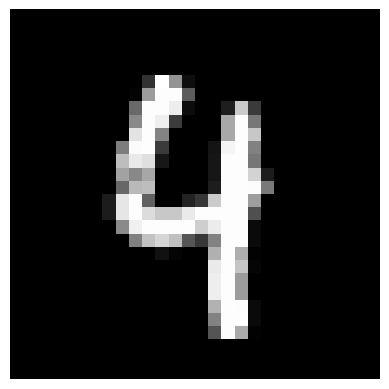

In [28]:
rand_idx = np.random.randint(len(y_test))
print(f'La imagen mostrada corresponde a un: {y_test[rand_idx]}')
plot_img_number(X_test_num[rand_idx])